In [2]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
import matplotlib.pyplot as plt

In [3]:
def evaluate_accuracy(data_iter, net):
  acc_sum, n = 0, 0
  net.eval()
  for X, y in data_iter:
    X, y = X.to(device), y.to(device)
    acc_sum += (net(X).argmax(axis=1) == y).sum()
    n += y.shape[0]
  return acc_sum.item() / n

In [4]:
def train(net, train_iter, test_iter, trainer, num_epochs):
  net.to(device)
  loss_list = [] # список для значений функции потерь на трейне
  best_acc = 0 # переменная для лучшего значения accuracy
  loss = nn.CrossEntropyLoss(reduction = 'sum')
  net.train()
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

    for i, (X, y) in enumerate(train_iter):
      X, y = X.to(device), y.to(device)
      trainer.zero_grad()
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      trainer.step()
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
      n += y.shape[0]

      if i % 100 == 0:
          print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")

    test_acc = evaluate_accuracy(test_iter, net.to(device))
    print(f'epoch {epoch + 1}, loss {train_l_sum / n}, train acc {train_acc_sum / n}, test acc {test_acc}, time {time.time() - start} sec')
    loss_list.append(train_l_sum / n)
    if test_acc > best_acc:
      best_acc = test_acc
  return loss_list, best_acc # будем возвращать список со значениями функции потерь на обучении и лучшую метрику на тесте

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    #lambda img: tv.transforms.functional.rotate(img, -90), # датасет почему-то был перевенутый и какой-то наклоненный, поэтому можно как вариант перевернуть все картинки,если будет плохая метрика
    #lambda img: tv.transforms.functional.hflip(img),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:34<00:00, 16333296.79it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [7]:
l = train_dataset.classes
l.sort()
print("No of classes: ",len(l))
print("List of all classes")
print(l)

No of classes:  47
List of all classes
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [8]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

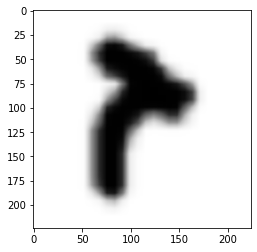

In [9]:
plt.imshow(train_dataset[0][0][0], cmap='Greys')

In [10]:
model = tv.models.resnet18(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
model = tv.models.vgg16(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [16]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=47, bias=True)
)

In [17]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [18]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [19]:
result_vgg = train(model, train_iter, test_iter, trainer, 10) 

Step 0. time since epoch: 16.434. Train acc: 0.023. Train Loss: 3.849
Step 100. time since epoch: 148.836. Train acc: 0.277. Train Loss: 4.344
Step 200. time since epoch: 281.531. Train acc: 0.515. Train Loss: 2.550
Step 300. time since epoch: 413.952. Train acc: 0.613. Train Loss: 1.889
Step 400. time since epoch: 546.384. Train acc: 0.669. Train Loss: 1.540
epoch 1, loss 1.4432402907364756, train acc 0.6843971631205674, test acc 0.8606382978723405, time 625.4750680923462 sec
Step 0. time since epoch: 1.315. Train acc: 0.902. Train Loss: 0.234
Step 100. time since epoch: 133.193. Train acc: 0.874. Train Loss: 0.351
Step 200. time since epoch: 265.025. Train acc: 0.877. Train Loss: 0.345
Step 300. time since epoch: 396.929. Train acc: 0.876. Train Loss: 0.346
Step 400. time since epoch: 528.959. Train acc: 0.877. Train Loss: 0.342
epoch 2, loss 0.34049793388826627, train acc 0.8772517730496454, test acc 0.8673936170212766, time 607.7992527484894 sec
Step 0. time since epoch: 1.320. Tra

In [20]:
result_vgg

([1.4432402907364756,
  0.34049793388826627,
  0.28274171714241625,
  0.24291649480238028,
  0.22057752693798524,
  0.19579807088730183,
  0.17573105779945428,
  0.16332276185353597,
  0.14855184362289753,
  0.13193407479752886],
 0.8895744680851064)

In [21]:
result_resnet = ([0.5592872849931109,
  2.920964143901852,
  0.6084141113741178,
  0.4228865988372911,
  0.36219063826486575,
  0.32793642713668497,
  0.3052651993095452,
  0.2834788239594047,
  0.2682398555972052,
  0.2522743683672966],
 0.8892021276595745)

Inception V3

In [22]:
model = tv.inception(

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
